In [1]:
# --- 1. 데이터 불러오기 ---
# 과제 조건: 100건 이상의 csv 데이터 사용, 라이브러리 내장 데이터 사용 금지

import pandas as pd
import numpy as np

# CSV 불러오기 (공지문구 15줄 스킵)
df = pd.read_csv("아파트(매매)_실거래가_20250921142106.csv", encoding="euc-kr", skiprows=15)

# 데이터 확인
print("데이터 크기:", df.shape)
print("컬럼:", df.columns)
df.head()

데이터 크기: (6536, 20)
컬럼: Index(['NO', '시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '계약년월', '계약일',
       '거래금액(만원)', '동', '층', '매수자', '매도자', '건축년도', '도로명', '해제사유발생일', '거래유형',
       '중개사소재지', '등기일자'],
      dtype='object')


,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
0,1,경기도 용인시 수지구 풍덕천동,699,699,0,한국,62.260,202509,18,"76,000",-,4,개인,개인,1995,정평로 116,-,중개거래,경기 용인시 수지구,-
1,2,경기도 용인시 수지구 죽전동,339,339,0,도담마을죽전파크빌,59.685,202509,17,"48,000",-,1,개인,개인,1997,정든로 22,-,중개거래,경기 용인시 수지구,-
2,3,경기도 용인시 수지구 죽전동,1116,1116,0,도담마을힐스테이트4차1단지,105.625,202509,17,"79,900",-,11,개인,개인,2003,푸른솔로 55,-,중개거래,"경기 용인시 기흥구, 경기 용인시 수지구",-
3,4,경기도 용인시 수지구 동천동,911,911,0,동천마을영풍아파트,59.970,202509,16,"59,800",-,7,개인,개인,2003,신수로783번길 22,-,중개거래,경기 용인시 수지구,-
4,5,경기도 용인시 수지구 죽전동,1302,1302,0,꽃메마을한라신영프로방스,148.864,202509,16,"110,000",-,8,개인,개인,2004,죽전로27번길 14-30,-,중개거래,경기 용인시 기흥구,-


In [13]:
# --- 2. 데이터 전처라 ---
# 1) 금액 숫자 변환 (쉼표, - 제거)
df["거래금액(만원)"] = (
    df["거래금액(만원)"].astype(str).str.replace(",","").str.replace("-","0")
)
df["거래금액(만원)"] = pd.to_numeric(df["거래금액(만원)"], errors="coerce").fillna(0).astype(int)

# 2) 숫자형 변환
num_cols = ["층","계약년월","계약일","건축년도"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# 3) 불필요한 컬럼 제거 (실제 있는 컬럼명만!)
drop_cols = [c for c in ["NO","번지","본번","부번","매수자","매도자","도로명","해제사유발생일","등기일자","동"] if c in df.columns]
df = df.drop(columns=drop_cols)

# 4) 원핫 인코딩 (실제 있는 범주형 컬럼만!)
cat_cols = [c for c in ["시군구","단지명","거래유형","중개사소재지"] if c in df.columns]
df_encoded = pd.get_dummies(df, columns=cat_cols)


In [15]:
# --- 3. 데이터 분할 (학습:테스트 = 8:2) ---
# 과제 조건: train_test_split 사용

from sklearn.model_selection import train_test_split

X = df_encoded.drop("거래금액(만원)", axis=1)
y = df_encoded["거래금액(만원)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((5228, 332), (1308, 332))

In [17]:
# --- 4. 회귀 알고리즘 적용 (3개) ---
# Linear Regression, Decision Tree, Random Forest

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 모델 정의
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

In [19]:
# --- 5. 성능 평가 ---
# RMSE, MAE, R² 출력

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}
    print(f"{name} 성능:")
    print("  RMSE:", rmse)
    print("  MAE :", mae)
    print("  R²  :", r2)
    print("-"*40)

Linear Regression 성능:
  RMSE: 531003487475.09265
  MAE : 43320395002.58978
  R²  : -668022741971290.1
----------------------------------------
Decision Tree 성능:
  RMSE: 5021.3902091978
  MAE : 3149.617737003058
  R²  : 0.9402628575937413
----------------------------------------
Random Forest 성능:
  RMSE: 3966.281082290893
  MAE : 2539.0952242609583
  R²  : 0.9627296494168308
----------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_22688\1162438533.py:23: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22688\1162438533.py:23: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22688\1162438533.py:23: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22688\1162438533.py:23: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22688\1162438533.py:23: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_22688\1162438533.py:23: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font

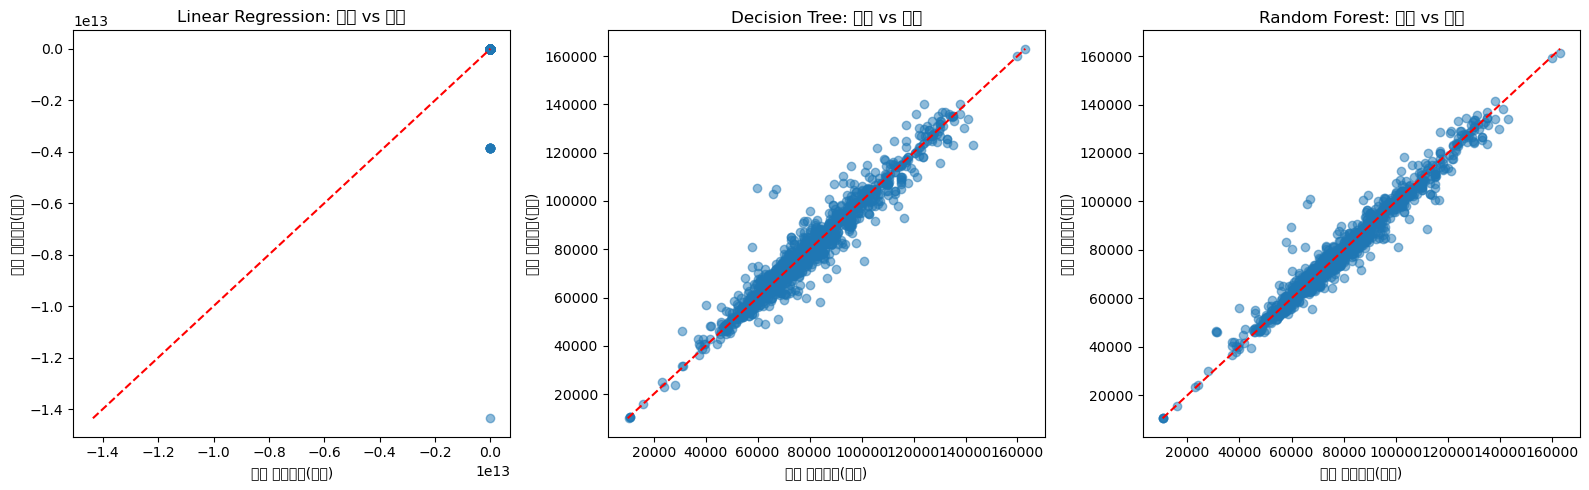

In [21]:
# ---6. 성능 지표 출력 ---
import matplotlib.pyplot as plt

# 모델 학습 및 예측
preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds[name] = model.predict(X_test)

# 시각화 (실제값 vs 예측값)
plt.figure(figsize=(16,5))

for i, (name, y_pred) in enumerate(preds.items(), 1):
    plt.subplot(1, 3, i)  # 1행 3열 i번째
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("실제 거래금액(만원)")
    plt.ylabel("예측 거래금액(만원)")
    plt.title(f"{name}: 실제 vs 예측")
    # 대각선(완벽한 예측선)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

In [23]:
# --- 7. 테스트 데이터 일부 결과 출력 ---

comparison = pd.DataFrame({
    "실제값": y_test.values[:10],
    "예측값": y_pred[:10].astype(int)
})
comparison


,실제값,예측값
0,76300,74674
1,77000,71932
2,105500,102347
3,93000,90528
4,78500,83475
5,139500,129950
6,69500,67773
7,73000,72952
8,69000,67834
9,104500,104088


In [25]:
# --- 8. 모델 저장/불러오기 ---

import joblib

# 모델 저장
joblib.dump(model, "apartment_price_model.pkl")

# 모델 불러오기
loaded_model = joblib.load("apartment_price_model.pkl")

# 불러온 모델로 예측
sample_pred = loaded_model.predict(X_test[:5])
print("불러온 모델 예측 결과:", sample_pred)


불러온 모델 예측 결과: [ 74674.    71932.   102347.    90528.    83475.75]
